# Who is paying and NOT paying the loan?
    - by Jay Ko and Richard Petrie

"On my honor, as a student, I have neither given nor received unauthorized aid on this academic work."

## About dataset
<br/>
<div style="text-align:justify">: This dataset was provided by Kaggle and can be accessed from here: [Lending-Club-Loan-Data](https://www.kaggle.com/wendykan/lending-club-loan-data). According to its description, <u>this dataset contains completed load data for all all loans issued through the 2007-2015, including the current loan status and latest payment information. This data set is a matrix of about 890,000 observations and 75 columns</u>

![](images/cash.jpg)

## Our mission
In order to provide meaningful analysis of LendingClub's customers, we first need to understand a little bit about the business and several key questions. LendingClub is a peer-to-peer loan provider, meaning they allow people to apply for loans, and other individuals or companies to furfil those loans. LendingClub itself needs not finance any loans with their own money, but has a responsability to its customers to verify that those who are applying for loans have the ability to pay in a timely manner. You can therefor think of LendingClub's role in these transactions as a credit auditor. 

The core queston for LendingClub becomes "Who can repay their loans?"

TODO ASK QUESTIONS

## Data processing
The first step to understanding our data is to clean up our data and identify columns that are important or not important. 

In [1]:
# Import basic data science packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# A helper function that converts 
# ["a", "b", "a", "c"] into
# [1, 2, 1, 3]
# This allows the machine learning algorithims to work on integers instead of strings
def categorize(l):
    uniques = sorted(list(set(l)))
    return [uniques.index(x) + 1 for x in l]

In [2]:
df = pd.read_csv("data/loan.csv")
df.head(3)

/Users/Jay/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data removal
We've identified several columns that fit into one of the following categories:
* Unneccesary data such as the URL to view the loan
* Redundant data. Loan description may be useful to some, but the much more conciese loan purpose fits our needs
* User provided information. Employer titles may offer some insight into employment industry, but would need significant cleanup to provide useful statistics
* Operational data. The next payment date for the loan at the time the data was generated is not relevant to us

In [3]:
# Drop unneccesary columns
df = df.drop(['url', 'desc', 'policy_code', 'last_pymnt_d', 'next_pymnt_d', 'earliest_cr_line', 'emp_title'], axis=1)
df = df.drop(['id', 'title', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'zip_code'], axis=1)

Additionally, we identified some rows that we decided were not relevant to our needs. The 'loan_status' column is the source of our answer to the core question if people are paying the loans they take out. We found some records with a loan_status of "Does not meet the credit policy". We believe these may be older loans that would simply not be accepted under LendingClubs current criteria. As these data points will provide no value moving forward, we've ecluded them from our data. Similiarily, recently issued loans could mislead our analysis, as no payment has been expected yet. 

In [4]:
# Filters out "Does not meet credit policy" loan statuses
# Removes 2,749 records
# Additionally drops "issued" loans
i = len(df)
df = pd.DataFrame(df[df['loan_status'] != "Does not meet the credit policy. Status:Fully Paid"])
df = pd.DataFrame(df[df['loan_status'] != "Does not meet the credit policy. Status:Charged Off"])
df = pd.DataFrame(df[df['loan_status'] != "Issued"])
df = pd.DataFrame(df[df['loan_status'] != "In Grace Period"])
a = len(df)
print(f"We dropped {i-a} rows")

We dropped 17462 rows


A significant amount of data remains, and we will move forward with the following columns remaining

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869917 entries, 0 to 887378
Data columns (total 61 columns):
member_id                      869917 non-null int64
loan_amnt                      869917 non-null float64
funded_amnt                    869917 non-null float64
funded_amnt_inv                869917 non-null float64
term                           869917 non-null object
int_rate                       869917 non-null float64
installment                    869917 non-null float64
grade                          869917 non-null object
sub_grade                      869917 non-null object
emp_length                     869917 non-null object
home_ownership                 869917 non-null object
annual_inc                     869917 non-null float64
verification_status            869917 non-null object
issue_d                        869917 non-null object
loan_status                    869917 non-null object
pymnt_plan                     869917 non-null object
purpose             

In [6]:
# We may have to drop columns with nulls
df.isnull().any()

member_id                      False
loan_amnt                      False
funded_amnt                    False
funded_amnt_inv                False
term                           False
int_rate                       False
installment                    False
grade                          False
sub_grade                      False
emp_length                     False
home_ownership                 False
annual_inc                     False
verification_status            False
issue_d                        False
loan_status                    False
pymnt_plan                     False
purpose                        False
addr_state                     False
dti                            False
delinq_2yrs                    False
inq_last_6mths                 False
mths_since_last_delinq          True
mths_since_last_record          True
open_acc                       False
pub_rec                        False
revol_bal                      False
revol_util                      True
t

## Analysis

We not begin to look at our data to better understand our demographics. We start by taking a look at the length of employment for our customers.

### A. Employement Length For Issued Loans

In [7]:
# make temporary dataframe in order to keep original dataframe
df_copy = df.copy()
df_copy["emp_length"] = ["0.5" if x == '< 1 year' else x for x in df_copy["emp_length"]]

# check employment length
df_copy.emp_length.unique()

array(['10+ years', '0.5', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a'], dtype=object)

In [8]:
# Using regex to easy convert

import re
reg = re.compile(r'(\d+\.?\d?)')
t = []
for emp in df_copy.emp_length:
    value = reg.match(emp)
    t.append(float(value[0]) if value else 0)
df_copy['emp'] = t

In [9]:
f = pd.value_counts(df_copy['emp']).to_frame().reset_index()
f.columns = ['type','count']

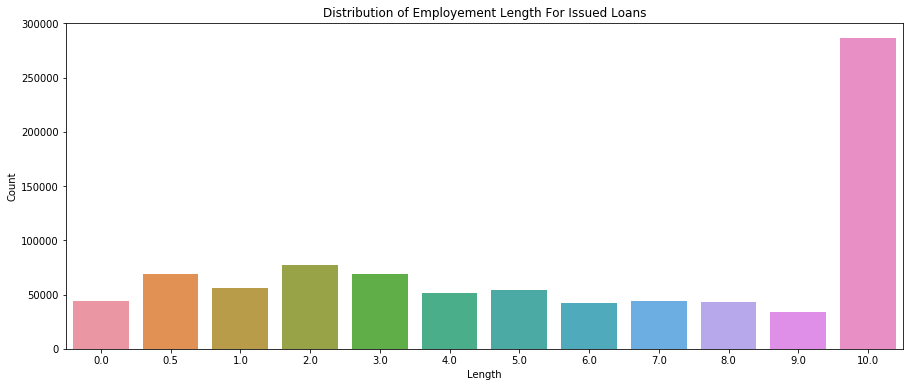

In [10]:
plt.subplots(figsize=(15,6))
sns.barplot(y='count', x='type', data=f)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Employement Length For Issued Loans")
plt.show()

### Summary
In the above chart we can see that a significant number of our customers have been employeed for 10 or more years. The data did not include the age of our customers, but from this data we can say that many of LendingClub customers are 30+.

Notes:
* The 10 year column is for 10+ years of employment, which is as high as the data went.
* The .5 year column is a replacement of the "< 1 year employment" value

### B. Loan Status

Next we wanted to take a look at some data points regarding the status of loans.

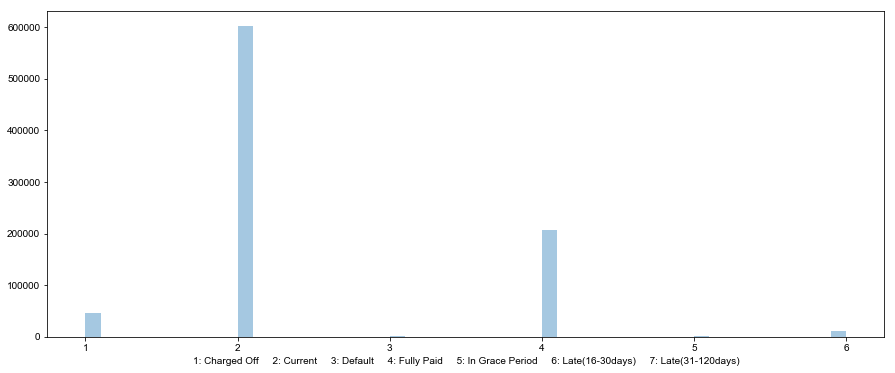

In [11]:
'''
legend = {6:("Late (16-30 days)",'b'),
          7:("Late (31-120 days)",'yellow'),
          5:("In Grace Period","k"),
          3:("Default",'magenta'),
          2:("Current", "orange"),
          1:("Charged Off","#512888"),
          4:("Fully Paid","#f7cfcf")}
'''
legend = "1: Charged Off     2: Current     3: Default     4: Fully Paid     5: In Grace Period     6: Late(16-30days)     7: Late(31-120days)"


plt.subplots(figsize=(15,6))

sns.set_context("paper", font_scale=2)
sns.set_style("white")
a = sns.distplot(categorize(df_copy["loan_status"]), kde=False)
a.set(xlabel=legend)
plt.legend()
plt.show()

In the above chart we can see that our loan status is highly imbalanced, with very few customers being late 16-30 days, and many customers being current or paid off. This will be important later.

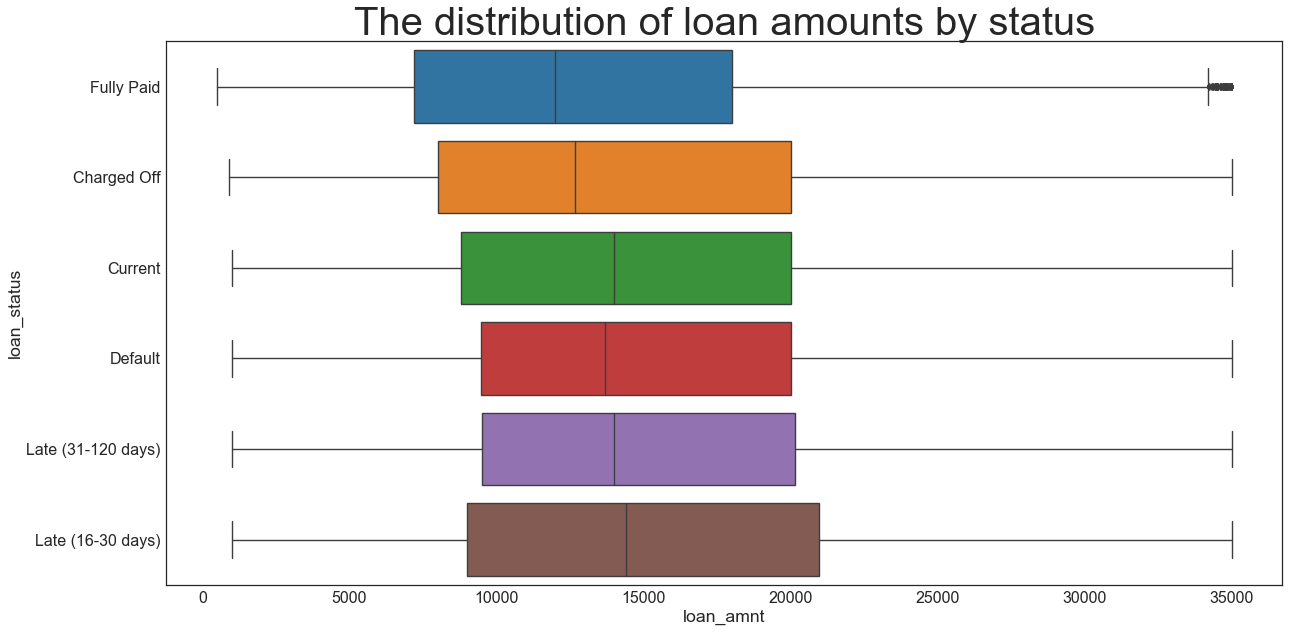

In [12]:
# Loan amount by its status
plt.subplots(figsize=(20,10))
plt.title("The distribution of loan amounts by status").set_size(40)
sns.boxplot(x="loan_amnt", y="loan_status", data=df_copy)

### Summary
- **Fully Paid** loans tend to be smaller. This could be due to the age of the loans
- **Default** has the highest count among other **loan status**.
- **In Grace Period** and **Late(16~30 days)** have the highest loan amount and mean.

### C. Loan Amount Base on Grade

The next question we wanted to answer was "What kind of loans are being issued?". We decided to approach this by the grade that LendingClub assigns to the loan. The Grade is a value from A to G that is a culmination of LendingClubs own analysis on the ability for the customer to repay the grade.

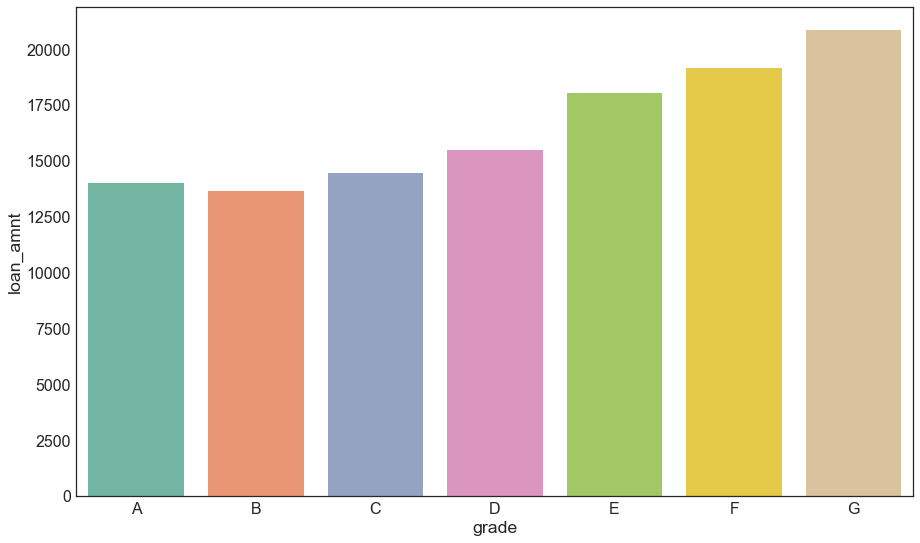

In [13]:
group = df_copy.groupby("grade").mean()
avg_loan = group['loan_amnt'].reset_index()
plt.subplots(figsize=(15,9))
sns.barplot(x='grade', y='loan_amnt', data=avg_loan, palette='Set2')

In [14]:
# clean plot
plt.clf()

### Summary
- The lower grade, the higher loan amount loan issued

## D. Loan status by grade
We were also curious how accurate LendingClub's Grades were. This is a look into what percentage of loans are current or already paid off by grade.


In [15]:
print("% of loans that are current or fully paid by grade")
print(f"A: {round((103322+39679)/(2617+103322+47+39679+365+134+492) * 100, 2)}%")
print(f"B: {round((171735+66546)/(9519+171735+198+66546+1240+410+2004) * 100, 2)}%")
print(f"C: {round((171175+52678)/(12642+171175+360+52678+1887+678+3339) * 100, 2)}%")
print(f"D: {round((91984+30020)/(10486+91984+312+30020+1405+369+2890) * 100, 2)}%")
print(f"E: {round((47061+12928)/(6258+47061+201+12928+908+368+1852) * 100, 2)}%")
print(f"F: {round((13589+4726)/(2934+13589+79+4726+354+155+768)* 100, 2)}%")
print(f"G: {round((2913+1146)/(792+2913+22+1146+94+42+246)* 100, 2)}%")
pd.pivot_table(df, index="loan_status", columns="grade", aggfunc="size")

% of loans that are current or fully paid by grade
A: 97.51%
B: 94.69%
C: 92.21%
D: 88.75%
E: 86.22%
F: 81.02%
G: 77.24%


grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,2617,9519,12642,10486,6258,2934,792
Current,103322,171735,171175,91984,47061,13589,2913
Default,47,198,360,312,201,79,22
Fully Paid,39679,66546,52678,30020,12928,4726,1146
Late (16-30 days),134,410,678,569,368,155,43
Late (31-120 days),492,2004,3339,2890,1852,768,246


### Sumarry
LendingClubs assigned Grades are actually fairly accurate, or at least logical. Lower graded loans are less likely to pay, as expected.

### E. Interest Rate base on Grade
We also wanted to look at the distribution of interst rate that loans are given, based on their LendingClub assigned grade.

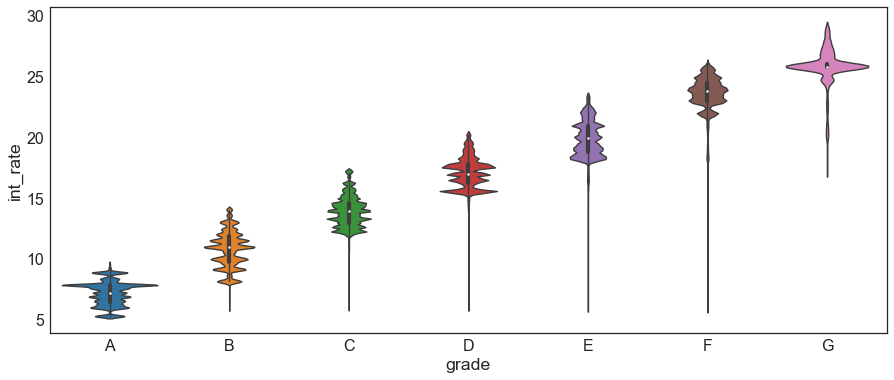

In [16]:
plt.subplots(figsize=(15,6))
sns.violinplot(x="grade", y="int_rate", data=df_copy, order="ABCDEFG")


### Summary
- Interest rate varies wildly, reaching nearly 30% for high-risk loans
- Grade **A** has the lowest interest rate around 7%
- Grade **G** has the highest interest rate above 25%

### F. Region

In [17]:
# Import map visulization libraries
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [18]:
# create dataframe that holds values by state.
loan_amnt_by_state = df_copy.groupby(["addr_state"]).sum()["loan_amnt"]
df_region = loan_amnt_by_state.to_frame()
df_region["loan_amnt"] = df_region["loan_amnt"].map("{:,.0f}".format)
temp = []
for x in df_region["loan_amnt"]:
    a = int(x.replace(',', ''))
    temp.append(a)
df_region["loan_amnt"] = temp

# count number of loan issued
num_issued_loan = df_copy.groupby(["addr_state"]).count()["member_id"]
df_region["num_issued"] = num_issued_loan

# Average loan amount
avg_loan_amnt_by_state = []
for a,b in zip(df_region["loan_amnt"], df_region["num_issued"]):
    temp = int(a/b)
    avg_loan_amnt_by_state.append(temp)
df_region["avg_loan_amnt_by_state"] = avg_loan_amnt_by_state

# Average employment length
total_year = df_copy.groupby(["addr_state"]).sum()["emp"]
temp = []
for a, b in zip(total_year, df_region.num_issued):
    value = (a/b)
    value = "{0:.2f}".format(value)
    value = float(value)
    temp.append(value)
df_region["avg_emp_length_by_state"] = temp

In [19]:
# change index 
df_region_copy = df_region.copy()
addr_state = df_region_copy.index

In [20]:
df_region.index = list(range(1,52))
df_region["addr_state"] = addr_state

In [21]:
# population by states from http://worldpopulationreview.com/states/

population = pd.read_csv("data/population.csv")
population.index = list(range(1,52))
df_region["population"] = population['2017 Population']



In [22]:
# Create another map
d = df_copy[df_copy["loan_status"].isin(["Late (16-30 days)","Late (31-120 days)","Default", "Charged Off", "Does not meet the credit policy. Status:Charged Off"])].groupby("addr_state").size()
d = d.to_frame()

e = pd.DataFrame([0],index=["ME"])
f = pd.concat([d,e])
f_copy = f.copy()
addr_state = f_copy.index
f.index = list(range(1,52))
f["addr_state"] = addr_state
f = f.sort_values(by="addr_state")
f.index = list(range(1,52))
df_region["num_default"] = f[0]

temp = []

for x, y in zip(df_region["num_default"], df_region["num_issued"].astype(int)):
    if x is not 0 and y is not 0:
        value = (x/y)
        value = "{0:.2f}".format(value)
        value = float(value)
        temp.append(value)
    else:
        temp.append(0)
df_region["default_rate"] = temp

# Average dti by the state
dti = df_copy.groupby("addr_state").agg([np.mean])["dti"]
dti.columns = ["dti"]
dti.index = list(range(1,52))
df_region = df_region.join(dti)

In [23]:
# plotly color setting
for col in df_region.columns:
    df_region[col] = df_region[col].astype(str)
    scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]


# create text column
df_region["text"] = df_region["addr_state"] + '<br>' + \
"Population: " + df_region["population"] + '<br>' + \
"Total loan amount ($ USD): " + df_region["loan_amnt"] + "<br>" + \
"Avg loan amount ($ USD): " + df_region["avg_loan_amnt_by_state"] + '<br>' + \
"Avg employment length (Years): " + df_region["avg_emp_length_by_state"] + "<br>" + \
"Default rate: " + df_region["default_rate"] + "<br>" + \
"DTI: " + df_region["dti"]


In [24]:
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_region['addr_state'],
        z = df_region['avg_loan_amnt_by_state'], 
        locationmode = 'USA-states',
        text = df_region['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "$s USD")
        ) ]

layout = dict(
        title = 'Lending Club Loan<br> Average Loan By State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

### Summary
- Alaska has the highest **Average Loan Amount**.
- California has the highest **Total Loan Amount**.

- Iowa has the highest **Default rate**.
- Maine has the highest **DTI** and 0% default rate

### G. Exploratory Data

In [25]:
# create new dataset for exploratory analysis
df_exp = pd.DataFrame()
df_exp['annual_inc'] = df_copy['annual_inc']
df_exp['delinq_2yrs'] = df_copy['delinq_2yrs']
df_exp['dti'] = df_copy['dti']
df_exp['emp_length'] = categorize(df_copy['emp_length'])
df_exp['grade'] = categorize(df_copy['grade'])
df_exp['home_ownership'] = categorize(df_copy['home_ownership'])
df_exp['installment'] = df_copy['installment']
df_exp['int_rate'] = df_copy['int_rate']
df_exp['loan_amnt'] = df_copy['loan_amnt']
df_exp['loan_status'] = categorize(df_copy['loan_status'])
df_exp['purpose'] = categorize(df_copy['purpose'])
df_exp['sub_grade'] = categorize(df_copy['sub_grade'])
df_exp['term'] = categorize(df_copy['term'])
df_exp['acc_now_delinq'] = df_copy['acc_now_delinq']


#### F-1. Heatmap

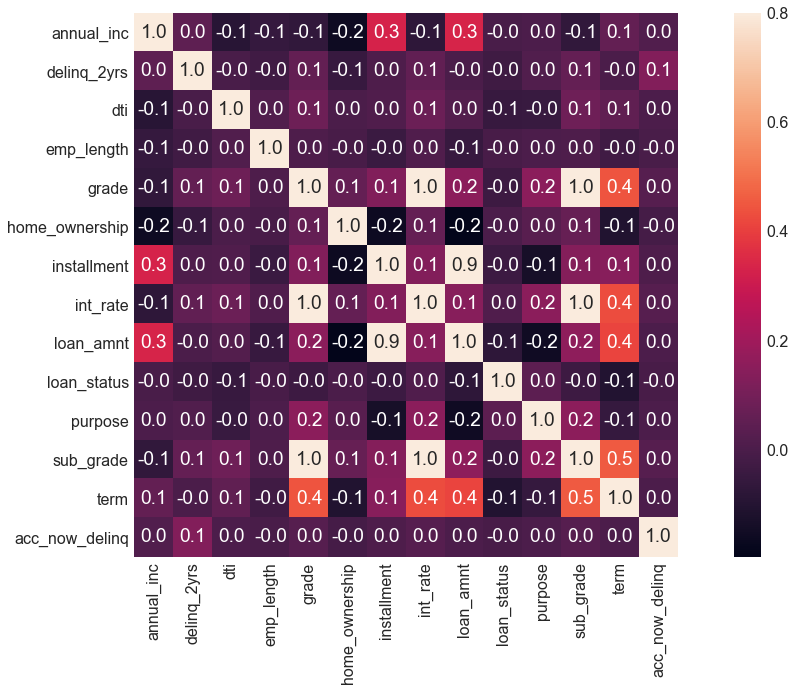

In [26]:
plt.figure(figsize=(20,10))
sns.set_context("paper", font_scale=2)
sns.heatmap(df_exp.corr(), vmax=.8, square=True, annot=True, fmt='.1f')

#### Summary
- **sub_grade** and **term** seem they have high correlation.
- Many factors(**grade**,**loan_amnt**,and **int_rate** seem they also have high correlation with **term**.
- It does not seem like **loan_status** is correlated to other factors

#### F-2 Statistical Testing

In [27]:
# import necessary libraries for statistical testing
from scipy import stats
from pandas.tools import plotting

Null Hypothesis
- There is no correlation between **grade** and **loan_status**.
- There is no correlation between **term** and **loan_status**.
- There is no correlation between **int_rate** and **loan_status**.


In [28]:
high_grade = df_exp[df_exp["grade"] < 4]["loan_status"]
low_grade = df_exp[df_exp["grade"] >= 4]["loan_status"]
two_samples = stats.ttest_ind(high_grade, low_grade)
print("The t-statistic is %.3f and the p-value is %.3f" % two_samples)

The t-statistic is 22.358 and the p-value is 0.000


- With low p-value, we can reject null hypothesis. It indicates there is correlation between **grade** and **loan_status**

In [29]:
shorter_term = df_exp[df_exp.term == 1]["loan_status"]
longer_term = df_exp[df_exp.term == 2]["loan_status"]
two_samples = stats.ttest_ind(shorter_term, longer_term)
print("The t-statistic is %.3f and the p-value is %.3f" % two_samples)

The t-statistic is 98.514 and the p-value is 0.000


- With low p-value, we can reject null hypothesis. It indicates there is correlation between **term** and **loan_status**

In [30]:
low_int_rate = df_exp[df_exp["int_rate"] < 16.00]["loan_status"]
high_int_rate = df_exp[df_exp["int_rate"] >= 16.00]["loan_status"]
two_samples = stats.ttest_ind(low_int_rate, high_int_rate)
print("The t-statistic is %.3f and the p-value is %.3f" % two_samples)

The t-statistic is 5.009 and the p-value is 0.000


- With low p-value, we can reject null hypothesis. It indicates there is correlation between **int_rate** and **loan_status**

### Summary
- On the simple **heatmap**, it is difficult to find correlation between **loan_status** and other factors
- However, on the statistical analysis, we also cannot ignore the heatmap result base on **null hypothesis analysis**
- We need to further analyse

![](images/statistics.jpg)

# Machine Learning
One thing that may be clear by now is that there is simply too much data to  accuratly understand the data without a significant time investment. Luckily, we no longer have to do the work. In this section we will look at some machine learning examples.

In [31]:
from sklearn import metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection

In [40]:
# Data set up
# TODO Make clean and normalize data
# TODO balance data
df_ml = pd.DataFrame()
df_ml['annual_inc'] = df['annual_inc']
df_ml['delinq_2yrs'] = df['delinq_2yrs']
df_ml['dti'] = df['dti']
df_ml['emp_length'] = categorize(df['emp_length'])
#df_ml['fico_range_high'] = df['fico_range_high']
#df_ml['fico_range_low'] = df['fico_range_low']
df_ml['grade'] = categorize(df['grade'])
df_ml['home_ownership'] = categorize(df['home_ownership'])
df_ml['installment'] = df['installment']
df_ml['int_rate'] = df['int_rate']
df_ml['loan_amnt'] = df['loan_amnt']
df_ml['loan_status'] = categorize(df['loan_status'])
#df_ml['mths_since_last_delinq'] = df['mths_since_last_delinq']
#df_ml['mths_since_last_major_derog'] = df['mths_since_last_major_derog']
df_ml['purpose'] = categorize(df['purpose'])
df_ml['sub_grade'] = categorize(df['sub_grade'])
df_ml['term'] = categorize(df['term'])
#df_ml['all_util'] = df['all_util']
df_ml['acc_now_delinq'] = df['acc_now_delinq']
#df_ml['tot_cur_bal'] = df['tot_cur_bal']
#df_ml['int_rate'] = [int(round(x)) for x in df['int_rate']]
#df_ml['int_rate'].unique()

df = pd.DataFrame(df[df['loan_status'] != "Fully Paid"])
df_ml['loan_status'] = [1 if x in [3, 5, 6] else x for x in df_ml['loan_status']]

In [41]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869917 entries, 0 to 887378
Data columns (total 14 columns):
annual_inc        869917 non-null float64
delinq_2yrs       869917 non-null float64
dti               869917 non-null float64
emp_length        869917 non-null int64
grade             869917 non-null int64
home_ownership    869917 non-null int64
installment       869917 non-null float64
int_rate          869917 non-null float64
loan_amnt         869917 non-null float64
loan_status       869917 non-null int64
purpose           869917 non-null int64
sub_grade         869917 non-null int64
term              869917 non-null int64
acc_now_delinq    869917 non-null float64
dtypes: float64(7), int64(7)
memory usage: 99.6 MB


In [42]:
df_ml.isnull().any()

annual_inc        False
delinq_2yrs       False
dti               False
emp_length        False
grade             False
home_ownership    False
installment       False
int_rate          False
loan_amnt         False
loan_status       False
purpose           False
sub_grade         False
term              False
acc_now_delinq    False
dtype: bool

### Splitting up the data set
Not only is it important to give our algorithms data to learn from, but also to test their accuracy. Here we run each algorithm twice with a perspective of our data.

The first algorithm simply splits the entire data set into two groups, the first 70% it learns from and it tests its accuracy on the remaining 30%.

The second algorithm uses an undersampling technique called One Sided Selection. Because a majority of our data fits into only 2 of our 7 loan status categories, we must be careful that our algorithm doesn't simply decide to put all loans into those two categories and call it a day. For this run, we use the undersampled data to train the algorithm and the entire dataset to test accuracy.

In [43]:
y = df_ml['loan_status']
X = df_ml.drop(['loan_status'], axis=1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

oss = OneSidedSelection()
X_resampled, y_resampled = oss.fit_sample(X, y)
#X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1)

/Users/Jay/anaconda/lib/python3.6/site-packages/imblearn/under_sampling/prototype_selection/one_sided_selection.py:197: DeprecationWarning:

in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.

/Users/Jay/anaconda/lib/python3.6/site-packages/imblearn/under_sampling/prototype_selection/one_sided_selection.py:197: DeprecationWarning:

in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.



In [45]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

print("Decision tree - Normal data set")
print(metrics.accuracy_score(y_test, dt.predict(X_test)))
print(metrics.confusion_matrix(y_test, dt.predict(X_test)))


dt = DecisionTreeClassifier()
dt.fit(X_resampled, y_resampled)
print("Decision tree - Imbalanced lean -One Sided Selection")
print(metrics.accuracy_score(y, dt.predict(X)))
print(metrics.confusion_matrix(y, dt.predict(X)))

Decision tree - Normal data set
0.664145362026
[[  2626   9005   6488]
 [ 10294 141747  28582]
 [  6982  26299  28953]]
Decision tree - Imbalanced lean -One Sided Selection
0.919329085418
[[ 60415      0      0]
 [  8189 579846  13744]
 [ 11210  37034 159479]]


In [46]:
dt = DecisionTreeClassifier(max_depth=5, max_features=5)
dt.fit(X_train, y_train)

print(metrics.accuracy_score(y_test, dt.predict(X_test)))
print(metrics.confusion_matrix(y_test, dt.predict(X_test)))

dt = DecisionTreeClassifier(max_depth=5, max_features=5)
dt.fit(X_resampled, y_resampled)

print(metrics.accuracy_score(y, dt.predict(X)))
print(metrics.confusion_matrix(y, dt.predict(X)))

0.707222120042
[[     0  15041   3078]
 [     0 168637  11986]
 [     0  46303  15931]]
0.699000019542
[[     0  55772   4643]
 [     0 593136   8643]
 [     0 192787  14936]]


In [47]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

print("Random Forest - Normal data set")
print(metrics.accuracy_score(y_test, clf.predict(X_test)))
print(metrics.confusion_matrix(y_test, clf.predict(X_test)))
print("\n")
clf = RandomForestClassifier()
clf.fit(X_resampled, y_resampled)

print("Random Forest - Imbalanced learn - One-sided Selection")
print(metrics.accuracy_score(y, clf.predict(X)))
print(metrics.confusion_matrix(y, clf.predict(X)))

Random Forest - Normal data set
0.734657593035
[[  1157  11620   5342]
 [  2588 164020  14015]
 [  2349  33334  26551]]


Random Forest - Imbalanced learn - One-sided Selection
0.914617141635
[[ 57959   1936    520]
 [  3613 589853   8313]
 [  5334  54560 147829]]


### Summary
As we can see, the second algorithm trained with the one sided selection data is significantly more accurate, reaching up to 89% accurate in classifying the loan status of our customers.